# Deep Mixture Networks

This notebook is a continuation of the neoneo notebook however with the intention of nailing down more of the sticky details than trying to get it to work. To that end, most of the actual mixture network things has been moved to the neoneo.py module and will simply be imported here for use.

The goal of this notebook is to experiment with performance improvements with changing the FeedForward function for example:

Does using the Malahanobis distance versus the log probability versus true probability improve the interestingness of the higher levels?

What kind of normalization can also help compensate.

How hard is it to learn from the final vector

Hopefully by moving these questions to this notebook, neoneo can be reserved for exploring more architecture-based questions

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal, Categorical
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.nn.utils.clip_grad import clip_grad_value_, clip_grad_norm_

import string
from random import *
import re
import math
import time

import subprocess, os, glob
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as st

device = 'cuda:2'
print (device)

print (os.getcwd())

print(torch.__version__)

from multimodal import MultiModalClassification
from GMM import *
from dennytools.silence import *

from neoneo import *

cuda:2
/home/tbjackso/MemStateEvolution
1.0.0


In [2]:
BS = 100

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

# Training dataset
big_batch = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=500, shuffle=True, pin_memory=False)

In [68]:
def forward(Ls, Ns, data, full=False):
    device = next(Ls[0].parameters()).device
    dd = data.to(device)
    
    Ys = [dd]

    for l,L in enumerate(Ls):
        (pi, sig, mu) = [x.cpu().detach() for x in L.params()]
        pi = pi.squeeze()
        vp,pp = pi.sort(descending=True)

        (y,_) = L(dd)

        # Normalize
        if (Ns is None):
            dd = y
        else:
            dd = Ns[l](y)
            
        Ys.append(y[:, pp])
        
    if (full):
        return Ys
    else:
        return Ys[-1]
    
def doEpoch(Ls, Ns, data_loader, learn):
    device = next(Ls[0].parameters()).device
    loss = [0 for L in Ls]
    for (data, label) in data_loader:
        p = data.to(device)
        for i,L in enumerate(Ls):
            # Calculate Forward
            (x,_) = L(p)

            # calculate loss
            loss[i] += L.loss(p).item()

            # Learn
            if (learn is True or learn == i):
                L.learn(p)

            # Normalize
            if (Ns is None):
                p = x
            else:
                p = Ns[i](x)

    loss.append(sum(loss))
    return loss
            

def train(Ls, Ns, data_loader, rounds, epochs, layer_learn=False, hardness=False, verbose=False):

    device = next(Ls[0].parameters()).device

    epochs = epochs*len(Ls) if (layer_learn) else epochs
    hist = np.zeros((rounds*epochs+1, len(Ls)+1))
    hard = np.zeros((rounds*epochs+1, len(Ls)))
    
    print ("Gathering Initial Statistics...")
    hist[0] = doEpoch(Ls, Ns, data_loader, False)
    
    if (hardness):
        for i in range(len(Ls)):
            hard[0, i] = MeasureHardness(Ls[:i+1], Ns, 30, data_loader, epochs=5, lr=5e-3, verbose=verbose)


    try:
        for r in range(rounds):
            s = time.time()
            print ("Round: {}/{}".format(r+1,rounds))

            for e in range(epochs):
                    
                if (layer_learn):
                    loss = doEpoch(Ls, Ns, data_loader, e//len(Ls))
                else:
                    loss = doEpoch(Ls, Ns, data_loader, True)

                # Measure hardness of each layer
                if (hardness):
                    for i in range(len(Ls)):
                        hard[epochs*r+e+1, i] = MeasureHardness(Ls[:i+1], Ns, 30, data_loader, epochs=5, lr=5e-3, verbose=verbose)

                hist[epochs*r+e+1] = loss

                print ("Epoch {} : {:.3f}, {:.3f}, {:.3f}, {:.3f} :: {:.3f}".format(*([e]+loss)))
            e = time.time()
            print ("Round {} runtime: {}\n".format(r,e-s))
            
    except KeyboardInterrupt:
        hist = hist[:(r*epochs)+e]
        hard = hard[:(r*epochs)+e]
    
    if (hardness):
        return (hist, hard)
    else:
        return hist

def plotMeans(Ls, sigma=False, stats=False, plot=True):

    for L in Ls:
        (pi, sig, mu) = [x.cpu().detach() for x in L.params(True)]
        pi = pi.squeeze()
        vp,pp = pi.sort(descending=True)
        print (pp)

        if (plot):
            if (sigma):
                pmu = sig[pp]
            else:
                pmu = mu[pp]
            rows = L.G//5

            fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
            for i in range(L.G):
                px = i//5
                py = i%5
                ax[px,py].imshow(pmu[i,0], cmap='gray')#, vmin=0, vmax=1)
            plt.show()
        
        if (stats):
            print ("Stats:")
            print ("Pi: Max: {} Mean: {} Min:{}".format(pi.max().item(), pi.mean().item(), pi.min().item()))
            print ("Sig: Max: {} Mean: {} Min:{}".format(sig.max().item(), sig.mean().item(), sig.min().item()))
            print ("Mu: Max: {} Mean: {} Min:{}".format(mu.max().item(), mu.mean().item(), mu.min().item()))
            
            
def plotActivations(Ls, Ns, data_loader, nsamples, scale=False, dists=False):
    (data, label) = next(iter(data_loader))
    device = next(Ls[0].parameters()).device
    
    nsamples = 1 if dists else nsamples

    for i in range(nsamples):
        dd = data.to(device)
        
        if (not dists):
            plt.imshow(data[i,0].cpu().detach(), cmap='gray', vmin=0, vmax=1)
            plt.show()

        for l,L in enumerate(Ls):
            (pi, sig, mu) = [x.cpu().detach() for x in L.params()]
            pi = pi.squeeze()
            vp,pp = pi.sort(descending=True)

            rows = L.G//5

            (y,_) = L(dd)
            
            # Normalize
            if (Ns is None):
                dd = y
            else:
                dd = Ns[l](y)
            
            # Activate scaling only if its a 1x1 image
            if (np.prod(dd[i,0].shape) == 1 or scale):
                vmin = dd[i].min()
                vmax = dd[i].max()
            else:
                vmin = None
                vmax = None

            fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
            for j in range(L.G):
                px = j//5
                py = j%5
                
                if (dists):
                    ax[px,py].hist(y[:,pp[j]].cpu().detach().flatten(), bins=50)
                else:
                    ax[px,py].imshow(dd[i,pp[j]].cpu().detach(), cmap='gray', vmin=vmin, vmax=vmax)
            plt.show()




            
# TODO 
# Define proper class for this deep conv net?
# Write function that trains one or two layer neural network against the outpits of
# the predictive learned behaviour and measures how quickly learning takes place
class FCNet(nn.Module):
    def __init__(self, inputs, hidden, classes):
        super(FCNet, self).__init__()
#         self.L1 = nn.Linear(inputs, hidden)
#         self.L2 = nn.Linear(hidden, classes)
        self.L  = nn.Linear(inputs, classes)
        self.inputs = inputs
        
    def forward(self, x):
        x1 = x.view(-1, self.inputs)
#         x2 = F.relu(self.L1(x1))
        x3 = self.L(x1)
#         x3 = self.L2(x2)
        return x3
        

def MeasureHardness(Ls, Ns, hidden, data_loader, epochs=10, lr=1e-3, verbose=False):
    device = next(Ls[0].parameters()).device
    
    net = FCNet(Ls[-1].G*Ls[-1].L, hidden, 10).to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    with silence(not verbose):
        hardness = 0
        for e in range(epochs):
            Tloss = 0
            Tacc = 0
            for data, label in data_loader:
                data = data.to(device)
                label = label.to(device)

                x = forward(Ls, Ns, data)

                opt.zero_grad()
                y = net(x)

                bloss = loss(y, label)
                Tloss += bloss.item()
                bloss.backward()

                opt.step()

                acc = (y.argmax(-1) == label).float().mean().item()

                Tacc += acc/len(data_loader)
                
            hardness += Tacc/epochs

            print ("Epoch: {} Acc: {:.2f} Loss: {:.2f}".format(e, 100*Tacc, Tloss))
            
    return hardness

def MeasureHardnessBaseline(CNet, inputs, hidden, data_loader, epochs=10, lr=1e-3, verbose=False):
    device = next(CNet.parameters()).device
    
    net = FCNet(inputs, hidden, 10).to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    with silence(not verbose):
        hardness = 0
        for e in range(epochs):
            Tloss = 0
            Tacc = 0
            for data, label in data_loader:
                data = data.to(device)
                label = label.to(device)

                x = CNet(data)

                opt.zero_grad()
                y = net(x)

                bloss = loss(y, label)
                Tloss += bloss.item()
                bloss.backward()

                opt.step()

                acc = (y.argmax(-1) == label).float().mean().item()

                Tacc += acc/len(data_loader)
                
            hardness += Tacc/epochs

            print ("Epoch: {} Acc: {:.2f} Loss: {:.2f}".format(e, 100*Tacc, Tloss))
            
    return hardness
    


In [36]:
class dummyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.A = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return x
    
CNet = dummyNet()

print (MeasureHardnessBaseline(CNet, 784, 0, train_loader, lr=5e-3, verbose=True))

Epoch: 0 Acc: 89.32 Loss: 230.01
Epoch: 1 Acc: 91.94 Loss: 172.79
Epoch: 2 Acc: 92.24 Loss: 165.90
Epoch: 3 Acc: 92.58 Loss: 161.10
Epoch: 4 Acc: 92.64 Loss: 158.83
Epoch: 5 Acc: 92.84 Loss: 156.74
Epoch: 6 Acc: 92.82 Loss: 154.89
Epoch: 7 Acc: 92.91 Loss: 153.26
Epoch: 8 Acc: 92.93 Loss: 152.62
Epoch: 9 Acc: 93.04 Loss: 151.35
0.9232500015869752


In [30]:
print (MeasureHardness(LsCS[:-1], NsCS, 30, train_loader, lr=5e-3, verbose=True))

Epoch: 0 Acc: 82.22 Loss: 513.50
Epoch: 1 Acc: 89.22 Loss: 248.55
Epoch: 2 Acc: 90.91 Loss: 202.00
Epoch: 3 Acc: 91.81 Loss: 178.58
Epoch: 4 Acc: 92.43 Loss: 163.70
Epoch: 5 Acc: 92.89 Loss: 152.97
Epoch: 6 Acc: 93.31 Loss: 144.55
Epoch: 7 Acc: 93.62 Loss: 138.05


KeyboardInterrupt: 

In [79]:
def mahalanobis(x, pi, sig, mu):
    x = x.unsqueeze(1)
    mal_dist = ((x-mu)**2/sig).sum(-1)
    return mal_dist

def cossim(x, pi, sig, mu):
    x = x.unsqueeze(1)/sig
    mu = mu/sig
    return F.cosine_similarity(x, mu, 2, 1e-8)

Gathering Initial Statistics...
Epoch: 0 Acc: 77.86 Loss: 28162.94
Epoch: 1 Acc: 83.49 Loss: 10641.21
Epoch: 2 Acc: 85.34 Loss: 11521.56
Epoch: 3 Acc: 85.41 Loss: 13750.19
Epoch: 4 Acc: 86.47 Loss: 14355.51
Epoch: 0 Acc: 61.43 Loss: 1102498.91
Epoch: 1 Acc: 76.55 Loss: 196012.76
Epoch: 2 Acc: 78.82 Loss: 195886.45
Epoch: 3 Acc: 79.03 Loss: 227722.00
Epoch: 4 Acc: 81.56 Loss: 217855.56
Epoch: 0 Acc: 46.84 Loss: 210111.51
Epoch: 1 Acc: 65.51 Loss: 49987.13
Epoch: 2 Acc: 66.62 Loss: 59398.03
Epoch: 3 Acc: 70.49 Loss: 56189.16
Epoch: 4 Acc: 71.21 Loss: 61077.10
Epoch: 0 Acc: 13.72 Loss: 678974.33
Epoch: 1 Acc: 23.80 Loss: 256017.07
Epoch: 2 Acc: 30.80 Loss: 191468.90
Epoch: 3 Acc: 35.24 Loss: 169195.79
Epoch: 4 Acc: 38.22 Loss: 156200.50
Epoch: 0 Acc: 10.19 Loss: 892586.27
Epoch: 1 Acc: 10.27 Loss: 784956.79
Epoch: 2 Acc: 10.13 Loss: 762009.64
Epoch: 3 Acc: 10.21 Loss: 748779.71
Epoch: 4 Acc: 10.27 Loss: 790779.40
Round: 1/1
Epoch: 0 Acc: 77.83 Loss: 31673.54
Epoch: 1 Acc: 83.82 Loss: 9978

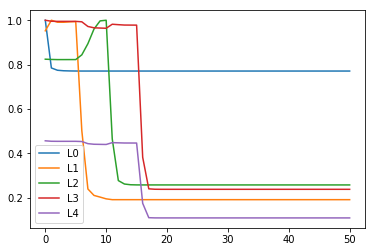

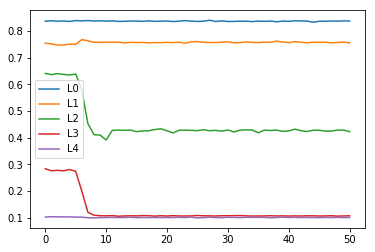

In [85]:
LsMD, NsMD = makeNet(mahalanobis, lambda x:x/x.mean(), device, Gs =[15,20,30,60,240], lr=[5e-3,0,5e-3])
# print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))

hist, hard = train(LsMD, NsMD, train_loader, 1, 10, layer_learn=True, hardness=True, verbose=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.legend()
plt.show()

Gathering Initial Statistics...
Epoch: 0 Acc: 81.62 Loss: 3358.45
Epoch: 1 Acc: 85.45 Loss: 1839.28
Epoch: 2 Acc: 86.05 Loss: 2196.10
Epoch: 3 Acc: 87.39 Loss: 2115.11
Epoch: 4 Acc: 87.16 Loss: 2332.98
Epoch: 0 Acc: 79.05 Loss: 497121.83
Epoch: 1 Acc: 83.27 Loss: 256064.97
Epoch: 2 Acc: 83.85 Loss: 284552.90
Epoch: 3 Acc: 84.63 Loss: 301854.29
Epoch: 4 Acc: 84.83 Loss: 308957.87
Epoch: 0 Acc: 70.58 Loss: 196308.05
Epoch: 1 Acc: 75.66 Loss: 101301.91
Epoch: 2 Acc: 75.97 Loss: 119046.82
Epoch: 3 Acc: 77.81 Loss: 113256.37
Epoch: 4 Acc: 77.57 Loss: 126307.77
Epoch: 0 Acc: 38.76 Loss: 396768.01
Epoch: 1 Acc: 51.15 Loss: 144262.42
Epoch: 2 Acc: 54.86 Loss: 141443.02
Epoch: 3 Acc: 57.79 Loss: 139201.96
Epoch: 4 Acc: 60.15 Loss: 131734.61
Epoch: 0 Acc: 10.69 Loss: 894757.23
Epoch: 1 Acc: 12.29 Loss: 615521.98
Epoch: 2 Acc: 13.61 Loss: 539085.88
Epoch: 3 Acc: 15.54 Loss: 467457.25
Epoch: 4 Acc: 16.15 Loss: 421581.72
Round: 1/1
Epoch: 0 Acc: 81.93 Loss: 2930.94
Epoch: 1 Acc: 85.93 Loss: 1791.26

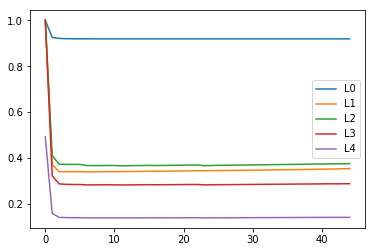

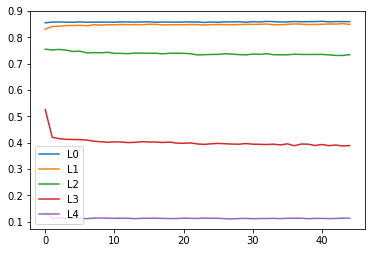

In [84]:
LsMD, NsMD = makeNet(mahalanobis, lambda x:x/x.mean(), device, Gs =[15,20,30,60,240], lr=[5e-3,0,5e-3], min_sig=1.0)
# print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))

hist, hard = train(LsMD, NsMD, train_loader, 1, 50, layer_learn=False, hardness=True, verbose=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.legend()
plt.show()

Gathering Initial Statistics...
Epoch: 0 Acc: 80.54 Loss: 29230.19
Epoch: 1 Acc: 84.57 Loss: 10592.51
Epoch: 2 Acc: 86.59 Loss: 10928.95
Epoch: 3 Acc: 86.77 Loss: 12568.55
Epoch: 4 Acc: 87.13 Loss: 13952.09
Epoch: 0 Acc: 78.92 Loss: 1009779.52
Epoch: 1 Acc: 84.18 Loss: 420394.10
Epoch: 2 Acc: 84.74 Loss: 486909.43
Epoch: 3 Acc: 85.20 Loss: 554037.50
Epoch: 4 Acc: 85.25 Loss: 629586.10
Epoch: 0 Acc: 71.64 Loss: 187218.20
Epoch: 1 Acc: 78.35 Loss: 74773.41
Epoch: 2 Acc: 79.72 Loss: 80048.14
Epoch: 3 Acc: 80.81 Loss: 80430.97
Epoch: 4 Acc: 80.10 Loss: 94623.63
Epoch: 0 Acc: 39.01 Loss: 299495.53
Epoch: 1 Acc: 56.19 Loss: 92500.13
Epoch: 2 Acc: 58.25 Loss: 101855.47
Epoch: 3 Acc: 63.17 Loss: 85181.05
Epoch: 4 Acc: 64.53 Loss: 86821.94
Epoch: 0 Acc: 10.57 Loss: 813881.19
Epoch: 1 Acc: 12.02 Loss: 599634.04
Epoch: 2 Acc: 13.11 Loss: 520219.54
Epoch: 3 Acc: 14.14 Loss: 458211.96
Epoch: 4 Acc: 15.76 Loss: 387539.49
Round: 1/1
Epoch: 0 Acc: 80.35 Loss: 22590.89
Epoch: 1 Acc: 85.07 Loss: 10512.7

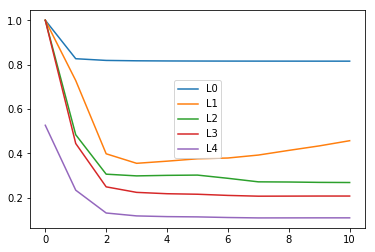

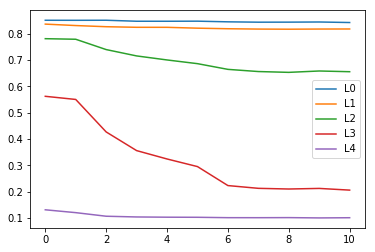

In [78]:
LsLP, NsLP = makeNet(MixtureLogProb, lambda x:x/x.mean(), device, Gs =[15,20,30,60,240], lr=[5e-3,0,5e-3])
# print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))

hist, hard = train(LsLP, NsLP, train_loader, 1, 10, layer_learn=False, hardness=True, verbose=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.legend()
plt.show()

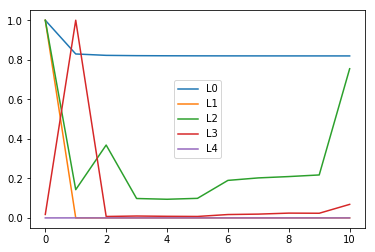

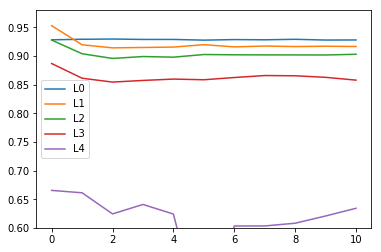

In [71]:
plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.ylim(bottom=0.6)
plt.legend()
plt.show()

In [81]:
# Cosine Similarity
def cossim(x, pi, sig, mu):
    x = x.unsqueeze(1)/sig
    mu = mu/sig
    return F.cosine_similarity(x, mu, 2, 1e-8)

def makeNet(func, N, device, Gs=[15,20,25,30,30], lr=5e-3, min_sig=0.01):

    L0 = CGMN((1,28,28), Gs[0], (3,3), lr=lr, FeedForward=func, min_sig=min_sig).eval()
    L0.to(device)

    L1 = CGMN((Gs[0],26,26), Gs[1], (3,3), stride=2, lr=lr, FeedForward=func, min_sig=min_sig).eval()
    L1.to(device)

    L2 = CGMN((Gs[1],12,12), Gs[2], (3,3), stride=2, lr=lr, FeedForward=func, min_sig=min_sig).eval()
    L2.to(device)

    L3 = CGMN((Gs[2],5,5), Gs[3], (3,3), lr=lr, FeedForward=func, min_sig=min_sig).eval()
    L3.to(device)
    
    L4 = CGMN((Gs[3],3,3), Gs[4], (3,3), lr=lr, FeedForward=func, min_sig=min_sig).eval()
    L4.to(device)

    Ls = [L0, L1, L2, L3, L4]
    Ns = [N]*len(Ls)
    return (Ls, Ns)

In [ ]:
# RUN THIS NEXT!!!!

Ls, Ns = makeNet(mahalanobis, lambda x:x/x.mean(), device, Gs=Gs[j], lr=[5e-3,5e-3,5e-3], min_sig=1)

for i in range(len(Ls)):
    hard.append(MeasureHardness(Ls[:i+1], Ns, 30, train_loader, epochs=5, lr=5e-3))
    print ("Layer {}: {}".format(i, hard[-1]))
    
hist, hard = train(Ls, Ns, train_loader, 1, 10, layer_learn=False, hardness=False, verbose=True)

for i in range(len(Ls)):
    hard.append(MeasureHardness(Ls[:i+1], Ns, 30, train_loader, epochs=5, lr=5e-3))
    print ("Layer {}: {}".format(i, hard[-1]))

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

In [77]:
Gs = [
    [15,20,25,30,30],
    [15,20,25,30,35],
    [15,20,25,40,30],
    [15,20,25,40,60],
    [15,20,30,60,240],
]

hard = np.zeros((len(Gs),len(Ls)))

for j in range(len(Gs)):
    print ("Network Shape: {}".format(Gs[j]))
    Ls, Ns = makeNet(cossim, lambda x:x/x.mean(), device, Gs=Gs[j], lr=[5e-3,0,5e-3])

    for i in range(len(Ls)):
        hard[j, i] = MeasureHardness(Ls[:i+1], Ns, 30, train_loader, epochs=5, lr=5e-3)
        print ("Layer {}: {}".format(i, hard[j,i]))


Network Shape: [15, 20, 25, 30, 30]
Layer 0: 0.9321699812809616
Layer 1: 0.9514933105160772
Layer 2: 0.9333266482924409
Layer 3: 0.8922233138158905
Layer 4: 0.6294766518883407
Network Shape: [15, 20, 25, 30, 35]
Layer 0: 0.9408799799929048
Layer 1: 0.9569566414306534
Layer 2: 0.9314133147398618
Layer 3: 0.8895266477564965
Layer 4: 0.636063319170227
Network Shape: [15, 20, 25, 40, 30]
Layer 0: 0.9258799817288913
Layer 1: 0.9503533111910005
Layer 2: 0.9240499820609878
Layer 3: 0.8954499813516933
Layer 4: 0.6618499846532944
Network Shape: [15, 20, 25, 40, 60]
Layer 0: 0.9374433138941713
Layer 1: 0.9567566419889506
Layer 2: 0.9328566483085348
Layer 3: 0.9058966480940573
Layer 4: 0.7627133143519351
Network Shape: [15, 20, 30, 60, 240]
Layer 0: 0.9261599818219732
Layer 1: 0.9523866441299498
Layer 2: 0.871623316325246
Layer 3: 0.8832299829938755
Layer 4: 0.705773316908626


In [11]:
device = 'cuda:7'


print (MeasureHardness(LsLG, NsLG, 100, train_loader, lr=5e-3, verbose=True))
LsCS, NsCS = makeNet(cossim, lambda x:x/x.mean(), device)
print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))
LsML, NsML = makeNet(MixtureLogProb, lambda x:x/x.mean(), device)
print (MeasureHardness(LsML, NsML, 100, train_loader, lr=5e-3, verbose=True))
LsMP, NsMP = makeNet(GMMProbs, lambda x:x/x.mean(), device)
print (MeasureHardness(LsMP, NsMP, 100, train_loader, lr=5e-3, verbose=True))

Epoch: 0 Acc: 36.71 Loss: 543956.26
Epoch: 1 Acc: 11.93 Loss: 1466.85
Epoch: 2 Acc: 11.61 Loss: 1397.49
Epoch: 3 Acc: 11.49 Loss: 1385.70
Epoch: 4 Acc: 11.56 Loss: 1381.64
Epoch: 5 Acc: 11.61 Loss: 1383.97
Epoch: 6 Acc: 11.40 Loss: 1382.23
Epoch: 7 Acc: 11.34 Loss: 1381.83
Epoch: 8 Acc: 11.28 Loss: 1380.50
Epoch: 9 Acc: 11.27 Loss: 1380.81
0.14020832962263366
Epoch: 0 Acc: 61.09 Loss: 706.24
Epoch: 1 Acc: 71.76 Loss: 513.54
Epoch: 2 Acc: 74.82 Loss: 459.98
Epoch: 3 Acc: 76.57 Loss: 430.79
Epoch: 4 Acc: 77.50 Loss: 412.22
Epoch: 5 Acc: 78.10 Loss: 400.61
Epoch: 6 Acc: 78.57 Loss: 391.77
Epoch: 7 Acc: 78.90 Loss: 384.72
Epoch: 8 Acc: 79.22 Loss: 379.12
Epoch: 9 Acc: 79.55 Loss: 374.36
0.756083314447353
Epoch: 0 Acc: 10.28 Loss: 13942.39
Epoch: 1 Acc: 11.24 Loss: 1380.84
Epoch: 2 Acc: 11.24 Loss: 1380.86
Epoch: 3 Acc: 11.24 Loss: 1380.91
Epoch: 4 Acc: 11.24 Loss: 1380.93
Epoch: 5 Acc: 11.15 Loss: 1380.94
Epoch: 6 Acc: 11.18 Loss: 1380.95
Epoch: 7 Acc: 11.18 Loss: 1380.91
Epoch: 8 Acc: 11.

In [4]:
class DeepCGMN(nn.Module):
    def __init__(self, N=lambda x:x, lr=1e-3):
        super().__init__()
        
        self.C0 = CGMN((1,28,28), 15, (3,3), lr=lr)
        self.C1 = CGMN((15,26,26), 20, (3,3), stride=2, lr=lr)
        self.C2 = CGMN((20,12,12), 25, (3,3), stride=2, lr=lr)
        self.C3 = CGMN((25,5,5), 30, (5,5), lr=lr)
        
        self.N = N
        
    def forward(self, x):
        (x1, _) = self.C0(x)
        x1 = self.N(x1)
        (x2, _) = self.C1(x1)
        x2 = self.N(x2)
        (x3, _) = self.C2(x2)
        x3 = self.N(x3)
        (y, _) = self.C3(x3)
        
        return y
    
    def learn(self, x, lr=None):
        (x1, _) = self.C0(x)
        x1 = self.N(x1)
        (x2, _) = self.C1(x1)
        x2 = self.N(x2)
        (x3, _) = self.C2(x2)
        x3 = self.N(x3)
        
        self.C0.learn(x, lr)
        self.C1.learn(x1, lr)
        self.C2.learn(x2, lr)
        self.C3.learn(x3, lr)
        
class ShellNet():
    def __init__(self, Ls, Ns):
        self.Ls = Ls
        self.Ns = Ns
    
    def forward(data):
        device = next(Ls[0].parameters()).device
        dd = data.to(device)

        for l,L in enumerate(Ls):
            (y,_) = L(dd)

            # Normalize
            if (Ns is None):
                dd = y
            else:
                dd = Ns[l](y)
                
        return dd
     
        

In [119]:
# Baseline comparison here I'm training a CNN to get a baseline for the hardness
# If the hardnesses are similar, it indicates that what is being learned from 
# the predictive rule is at least as good to learn from as a trained CNN
# we also want to compare to an untrained CNN in order to get upper and lower limits

In [12]:
   
class DeepCNN(nn.Module):
    def __init__(self, N=F.relu):
        super().__init__()
        
        self.C0 = nn.Conv2d(1, 15, 3)
        self.C1 = nn.Conv2d(15, 20, 3, stride=2)
        self.C2 = nn.Conv2d(20, 25, 3, stride=2)
        self.C3 = nn.Conv2d(25, 30, 5)
        
        self.N = N
        
    def forward(self, x):
        x1 = self.C0(x)
        x1 = self.N(x1)
        x2 = self.C1(x1)
        x2 = self.N(x2)
        x3 = self.C2(x2)
        x3 = self.N(x3)
        y = self.C3(x3)
        
        return y
    
    def learn(self, x, lr=None):
        pass

CNet = DeepCNN().to(device)
FNet = FCNet(30, 100, 10).to(device)

optC = optim.Adam(CNet.parameters(), lr=5e-3)
optF = optim.Adam(FNet.parameters(), lr=5e-3)

criteria = nn.CrossEntropyLoss()

epochs = 5

for e in range(epochs):
    TLoss = 0
    TAcc = 0
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optC.zero_grad()
        optF.zero_grad()
        x = CNet(data)
        y = FNet(x)
        
        loss = criteria(y, label)
        TLoss += loss.item()
        loss.backward()
        
        optC.step()
        optF.step()
        
        acc = (y.argmax(-1) == label).float().mean().item()

        TAcc += acc/len(train_loader)
        
    print ("Epoch {}: {:.2f}% {:.2f}".format(e, TAcc*100, TLoss))
        
print (MeasureHardnessBaseline(CNet, 30, 100, train_loader, lr=5e-3, verbose=True))
CNet = DeepCNN().to(device)
print (MeasureHardnessBaseline(CNet, 30, 100, train_loader, lr=5e-3, verbose=True))
        
        

Epoch 0: 93.93% 119.15
Epoch 1: 97.83% 42.37
Epoch 2: 98.18% 34.96
Epoch 3: 98.47% 29.37
Epoch 4: 98.52% 28.20
Epoch: 0 Acc: 98.32 Loss: 36.43
Epoch: 1 Acc: 99.00 Loss: 19.65
Epoch: 2 Acc: 99.08 Loss: 17.55
Epoch: 3 Acc: 99.18 Loss: 16.14
Epoch: 4 Acc: 99.22 Loss: 15.25
Epoch: 5 Acc: 99.27 Loss: 14.21
Epoch: 6 Acc: 99.24 Loss: 14.34
Epoch: 7 Acc: 99.30 Loss: 13.47
Epoch: 8 Acc: 99.37 Loss: 12.07
Epoch: 9 Acc: 99.34 Loss: 12.28
0.9913200071454062
Epoch: 0 Acc: 39.52 Loss: 1105.10
Epoch: 1 Acc: 59.61 Loss: 733.27
Epoch: 2 Acc: 63.09 Loss: 651.89
Epoch: 3 Acc: 65.78 Loss: 609.74
Epoch: 4 Acc: 68.11 Loss: 576.31
Epoch: 5 Acc: 69.60 Loss: 551.42
Epoch: 6 Acc: 70.96 Loss: 532.08
Epoch: 7 Acc: 71.77 Loss: 517.74
Epoch: 8 Acc: 72.58 Loss: 506.35
Epoch: 9 Acc: 73.20 Loss: 495.66
0.6542266673911362


hello
Round: 1/1
Epoch 0 : -1691.845, 598946.343, 683039.036, 2784826.374 :: 4065119.906
Epoch 1 : -10609.874, 839770.426, 764065.213, 3115829.210 :: 4709054.974
Epoch 2 : -12300.843, 828741.134, 641658.557, 2839613.012 :: 4297711.860
Epoch 3 : -12795.952, 866668.911, 620892.608, 2773919.028 :: 4248684.595
Epoch 4 : -12812.498, 201721.509, 747635.384, 2947329.368 :: 3883873.763
Epoch 5 : -12812.498, 46008.368, 1260383.541, 3371794.967 :: 4665374.379
Epoch 6 : -12812.498, 35104.852, 1303496.340, 3374159.769 :: 4699948.463
Epoch 7 : -12812.498, 31665.015, 1262217.548, 3356478.888 :: 4637548.954
Epoch 8 : -12812.498, 30606.336, 325777.500, 3512244.564 :: 3855815.902
Epoch 9 : -12812.498, 30606.885, 118031.515, 3638015.808 :: 3773841.710
Epoch 10 : -12812.498, 30607.212, 112167.961, 3609276.523 :: 3739239.198
Epoch 11 : -12812.498, 30606.609, 109689.608, 3590819.249 :: 3718302.968
Epoch 12 : -12812.498, 30606.834, 106737.689, 874517.650 :: 999049.675
Epoch 13 : -12812.498, 30607.270, 10673

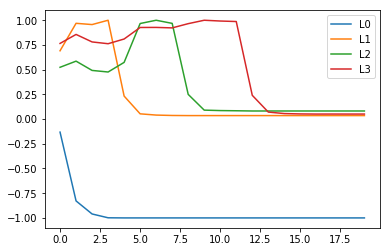

In [102]:


# Quick test
lr = 5e-3
L0 = CGMN((1,28,28), 15, (3,3), lr=lr).eval()
L0.to(device)

L1 = CGMN((15,26,26), 20, (3,3), stride=2, lr=lr).eval()
L1.to(device)

L2 = CGMN((20,12,12), 25, (3,3), stride=2, lr=lr).eval()
L2.to(device)

L3 = CGMN((25,5,5), 30, (5,5), lr=lr).eval()
L3.to(device)

Ls = [L0, L1, L2, L3]
Ns = [lambda x: x/x.mean()]*len(Ls)

hist = train(Ls, Ns, train_loader, 1, 10, layer_learn=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.legend()
plt.show()

hello
Round: 1/1
Epoch 0 : -3181.127, 221990245.815, 128638100661.601, 2478072301186.609 :: 2606932388912.897
Epoch 1 : -12553.813, 1270508.871, 33999373063.234, 144532338.906 :: 34145163357.198
Epoch 2 : -12999.670, 1406016.095, 89371353743712.531, 346371834.391 :: 89371701508563.344
Epoch 3 : -13136.527, 1497414.800, 13906232455.330, 409519217.469 :: 14317235951.072
Epoch 4 : -13159.092, 367943.507, 387161001.611, 59347576.398 :: 446863362.424
Epoch 5 : -13159.092, 171032.603, 1218366.526, 30435481.252 :: 31811721.288
Epoch 6 : -13159.092, 149539.553, 912528.834, 18679517.754 :: 19728427.048
Epoch 7 : -13159.092, 141291.647, 837679.557, 22078571.264 :: 23044383.374
Epoch 8 : -13159.092, 139602.003, 237866.106, 1821060560635402.250 :: 1821060560999711.250
Epoch 9 : -13159.092, 139600.958, 123137.046, 114251778.438 :: 114501357.349
Epoch 10 : -13159.092, 139601.256, 116638.842, 110946191.539 :: 111189272.545
Epoch 11 : -13159.092, 139600.699, 114993.101, 105321493.484 :: 105562928.191


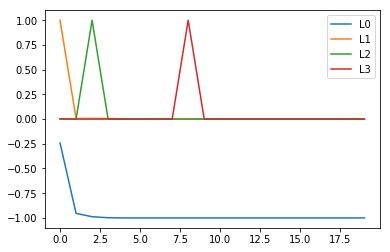

In [108]:
# Cosine Similarity
def cossim(x, pi, sig, mu):
    x = x.unsqueeze(1)/sig
    mu = mu/sig
    return F.cosine_similarity(x, mu, 2, 1e-8)

func = cossim

lr = 5e-3
L0 = CGMN((1,28,28), 15, (3,3), lr=lr, FeedForward=func).eval()
L0.to(device)

L1 = CGMN((15,26,26), 20, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L1.to(device)

L2 = CGMN((20,12,12), 25, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L2.to(device)

L3 = CGMN((25,5,5), 30, (5,5), lr=lr, FeedForward=func).eval()
L3.to(device)

Ls = [L0, L1, L2, L3]
Ns = [lambda x: x/x.mean()]*len(Ls)

raise ValueError("STOP")

hist = train(Ls, Ns, train_loader, 1, 5, layer_learn=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.legend()
plt.show()

In [9]:
func = MixtureLogProb

lr = 5e-3
L0 = CLGMN((1,28,28), 15, 15, (3,3), lr=lr, FeedForward=func).eval()
L0.to(device)

L1 = CLGMN((15,26,26), 20, 20, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L1.to(device)

L2 = CLGMN((20,12,12), 25, 25, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L2.to(device)

L3 = CLGMN((25,5,5), 30, 30, (5,5), lr=lr, FeedForward=func).eval()
L3.to(device)

Ls = [L0, L1, L2, L3]
Ns = [lambda x: x/x.mean()]*len(Ls)

raise ValueError("Stop")
hist = train(Ls, Ns, train_loader, 1, 10, layer_learn=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.legend()
plt.show()

ValueError: Stop

In [10]:
LsLG = Ls
NsLG = Ns

tensor([14,  3, 11,  0,  5, 13, 10,  4, 12,  2,  6,  9,  7,  1,  8])
Stats:
Pi: Max: 0.3235808312892914 Mean: 0.06666667014360428 Min:0.0016354297986254096
Sig: Max: 9.923660278320312 Mean: 0.7640866041183472 Min:0.009999999776482582
Mu: Max: 2.8578836917877197 Mean: -0.12279953807592392 Min:-3.3876969814300537
tensor([10, 16, 19, 15, 13,  6, 14,  2,  3,  0,  4, 17,  8, 18,  7,  1,  9,  5,
        11, 12])
Stats:
Pi: Max: 0.5571426153182983 Mean: 0.04999999329447746 Min:0.004629899747669697
Sig: Max: 22.973236083984375 Mean: 2.55195689201355 Min:0.06800184398889542
Mu: Max: 2.6802167892456055 Mean: 0.054932307451963425 Min:-2.1720125675201416
tensor([ 2,  7,  1, 12, 21, 16,  4,  6, 15, 18, 17,  0,  8, 13, 10, 14,  9,  5,
        22, 11, 24, 23, 19,  3, 20])
Stats:
Pi: Max: 0.46503832936286926 Mean: 0.040000006556510925 Min:0.0006314584170468152
Sig: Max: 19.57112693786621 Mean: 2.4735331535339355 Min:0.0709274560213089
Mu: Max: 3.3410162925720215 Mean: -0.05877576395869255 Min:-2.80143

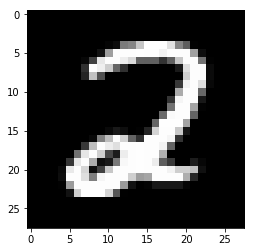

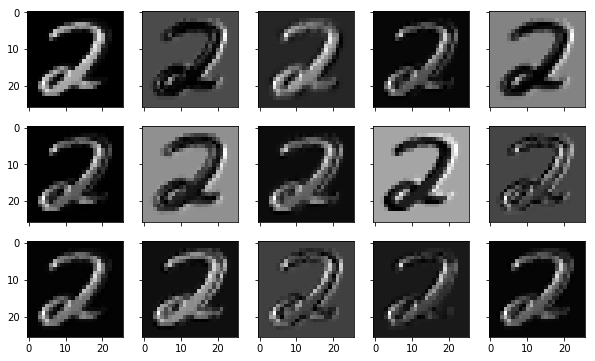

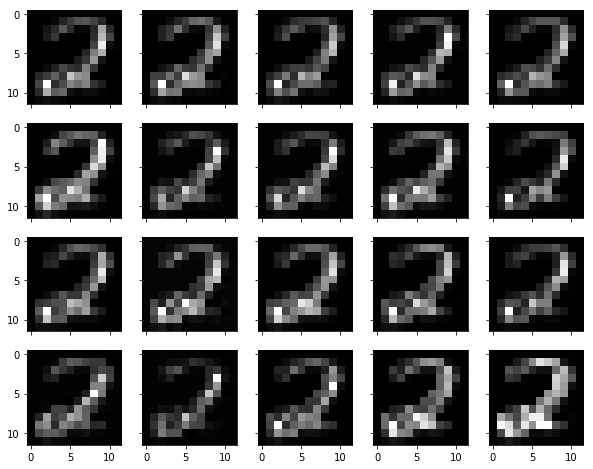

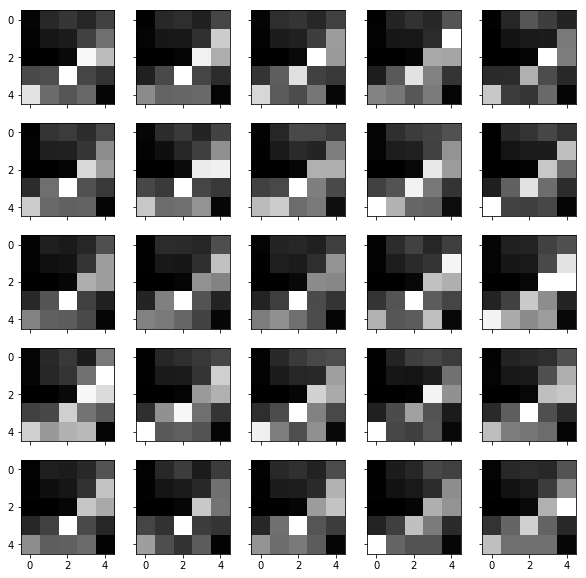

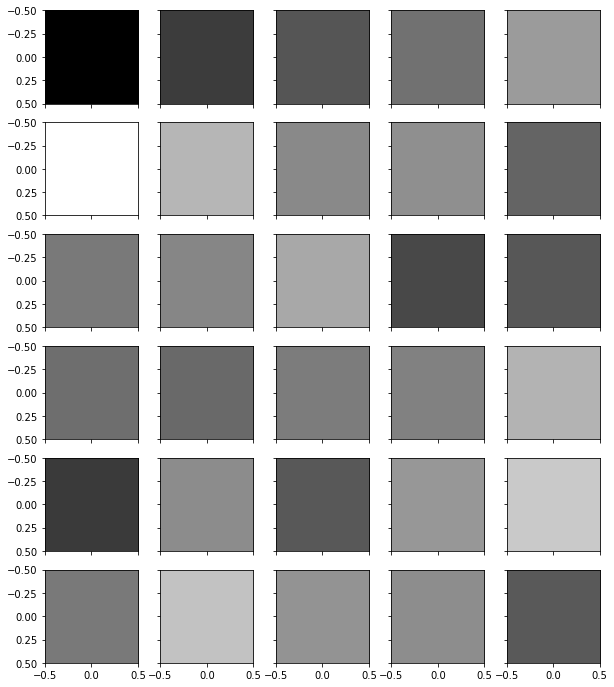

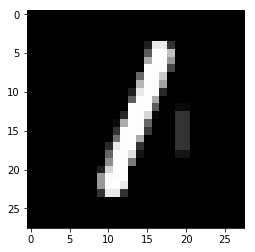

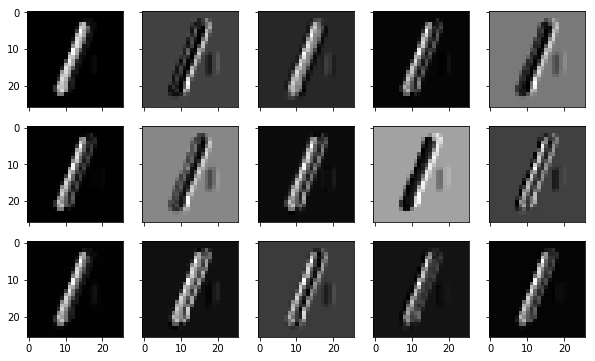

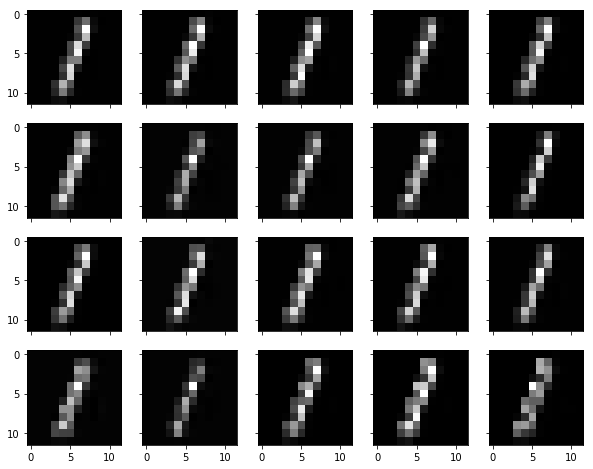

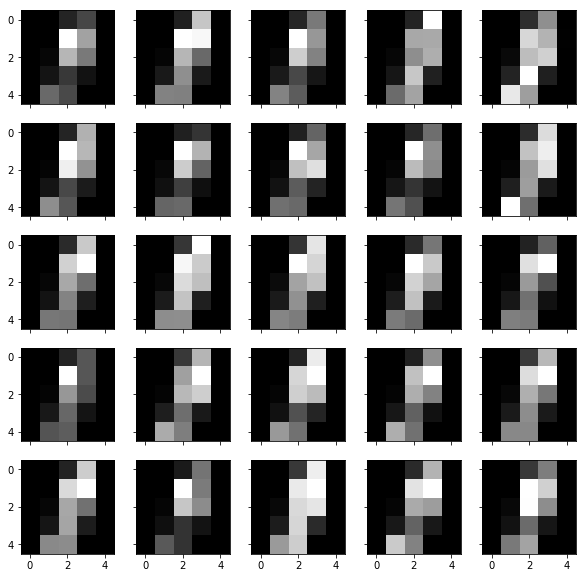

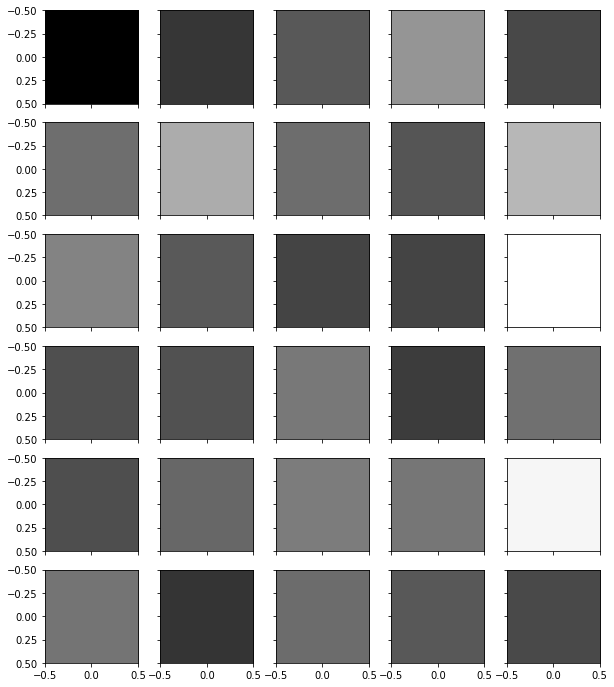

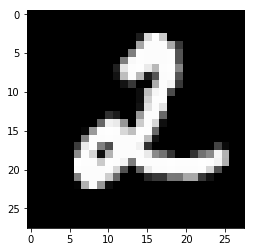

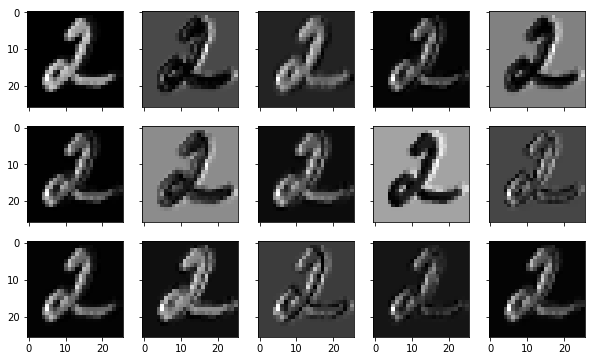

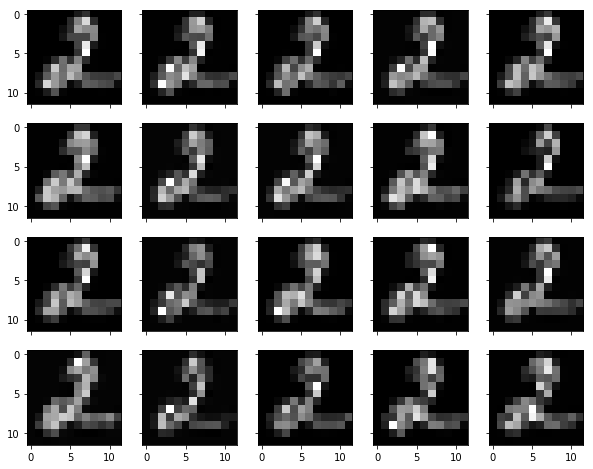

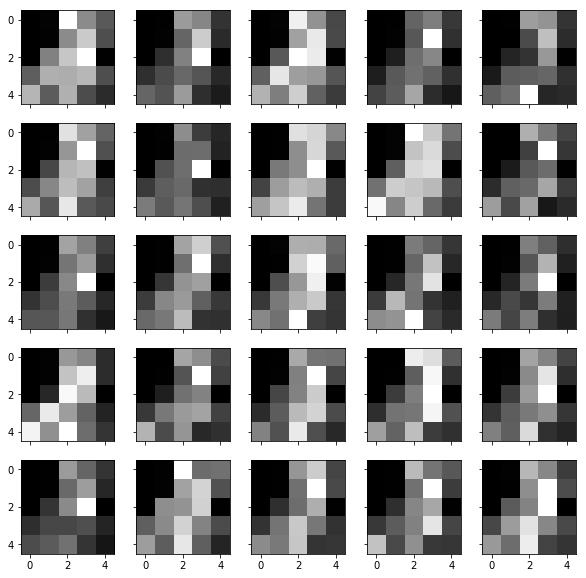

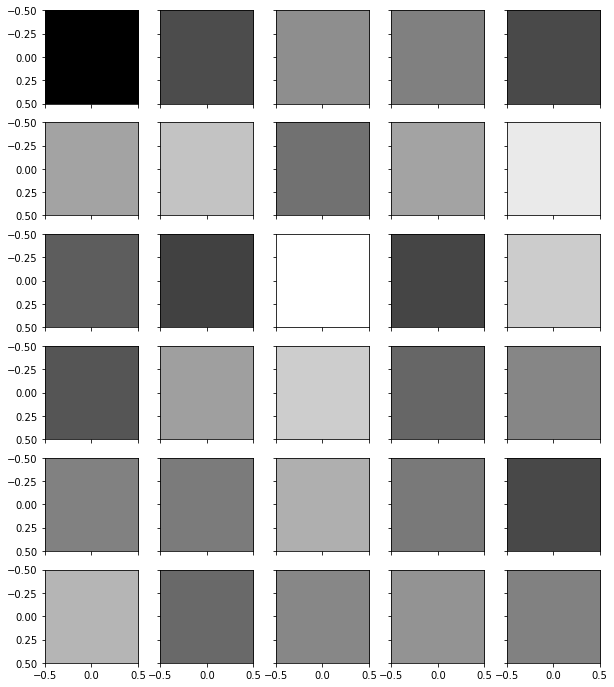

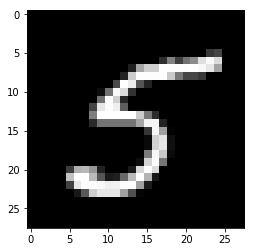

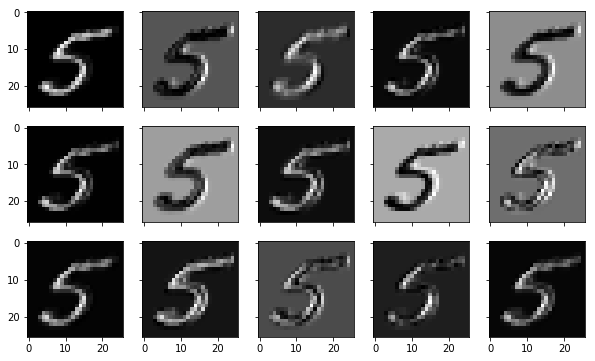

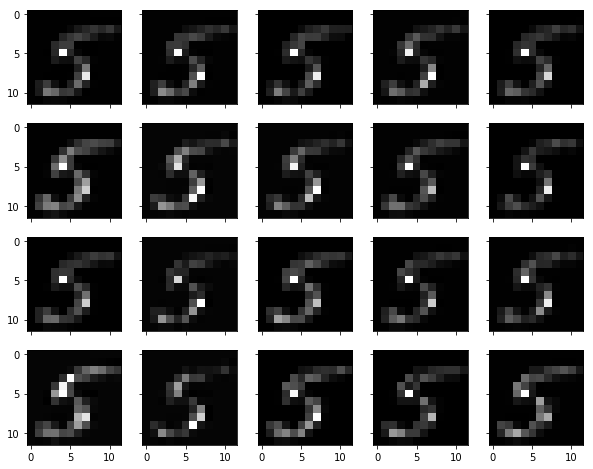

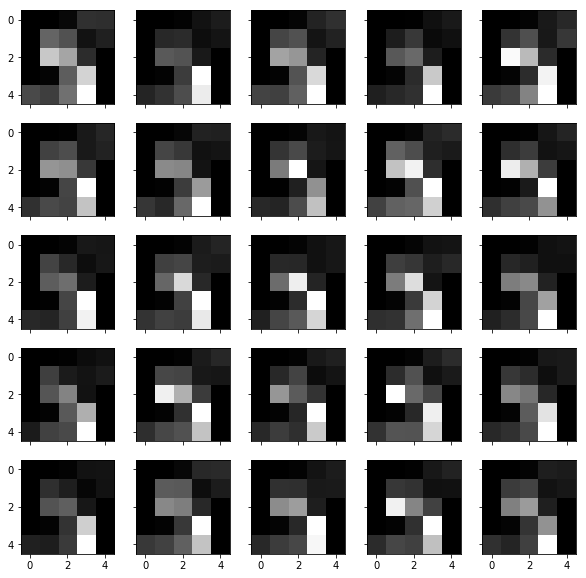

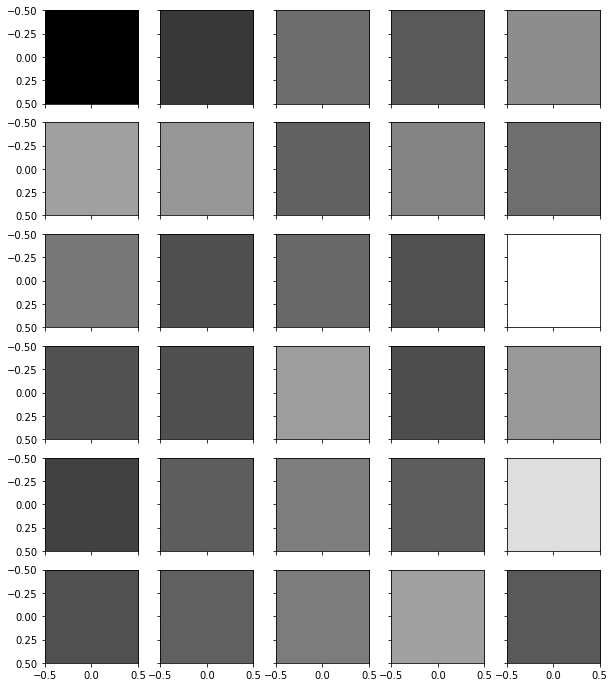

In [81]:
plotMeans(Ls, stats=True, plot=False)
plotActivations(Ls, Ns, big_batch, 4)

In [82]:

class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()
        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))
        
        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))
        
    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1
        
        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)
        
        return m_hat / (torch.sqrt(v_hat) + self.eps)

def cleanlr(lr, l):
    if (not isinstance(lr, (list, tuple))):
        lr = [lr]*l

    if (len(lr) != l):
        raise ValueError("Learning Rates must be length 3")
        
    return lr

class GMN(nn.Module):
    def __init__(self, inputs, gaussians, lr=1e-3, min_sig=0.01,
                 Loss=GMMLoss, FeedForward=MixtureLogProb):
        super(GMN, self).__init__()
        self.inputs = inputs
        self.gaussians = gaussians
        
        self.Pis = nn.Parameter(torch.randn((1, gaussians)))
        self.Sigs = nn.Parameter(torch.randn((1, gaussians, inputs)))
        self.Mus = nn.Parameter(torch.randn((1, gaussians, inputs)))
    
        self.Pi_adam = Adam(self.Pis)
        self.Sig_adam = Adam(self.Sigs)
        self.Mu_adam = Adam(self.Mus)
        
        self.lr = cleanlr(lr, 3)
        self.min_sig = torch.log(torch.tensor(min_sig))
        
        self.FF = FeedForward
        self._loss = Loss
    
    def params(self):  
        Pis = F.softmax(self.Pis, dim=1)
        Sigs = self.Sigs.exp()
        Mus =  self.Mus
        
        return (Pis, Sigs, Mus)
    
    def forward(self, x, lr=None):
        # This returns both the p vector to higher levels and the dP/dx for feed back
        # If in training mode it will also perform update of this layer's parameters
        
        (pi, sig, mu) = self.params()
        
        xt = torch.zeros_like(x, requires_grad=True)
        xt.data = x
        x = xt
        
        # Do parameter learning
#         if (self.training):
#             self.learn(x, lr)
            
        p = self.FF(x, pi, sig, mu)
        
        # Calculate backwards vector
        loss = self._loss(x, pi, sig, mu)
        loss.backward()
        dpdx = x.grad
        
        return (p.detach(), dpdx.detach())
    
    def learn(self, x, lr=None):
        
        (pi, sig, mu) = self.params()
        
        if (lr is None):
            lr = self.lr
        lr = cleanlr(lr, 3)
            
        self.Pis.grad = torch.zeros_like(self.Pis)
        self.Sigs.grad = torch.zeros_like(self.Sigs)
        self.Mus.grad = torch.zeros_like(self.Mus) 
            
        loss = self._loss(x, pi, sig, mu)
        loss.backward()
        
        self.Pis.data  -= lr[0]*self.Pi_adam(self.Pis.grad)
        self.Sigs.data -= lr[1]*self.Sig_adam(self.Sigs.grad)#.clamp(0.01)
        self.Mus.data  -= lr[2]*self.Mu_adam(self.Mus.grad)
        
        # Range bounding
        self.Sigs.data = torch.clamp(self.Sigs, min=self.min_sig)
        
    def loss(self, x):
        (pi, sig, mu) = self.params()
        return self._loss(x, pi, sig, mu)
    
class LGMN(GMN):
    def __init__(self, inputs, hiddens, gaussians, lr=1e-3, min_sig=0.01,
                 Loss=GMMLoss, FeedForward=MixtureLogProb):
        super(LGMN, self).__init__(hiddens, gaussians, lr=1e-3, min_sig=0.01,
                 Loss=GMMLoss, FeedForward=MixtureLogProb)
        
        self.W = nn.Parameter(torch.randn((inputs, hiddens)))
        self.b = nn.Parameter(torch.zeros(hiddens))
        
        self.W_adam = Adam(self.W)
        self.b_adam = Adam(self.b)
        

    def forward(self, x):
        x1 = torch.einsum('ij,bi->bj', [self.W, x]) + self.b
        (y, dydx1) = super(LGMN, self).forward(x1)
        dydx = torch.einsum('ij,bj->bi', [self.W, dydx1])
        return (y, dydx)
    
    def learn(self, x, lr=None):
    
        if (lr is None):
            lr = self.lr
            
        self.W.grad = torch.zeros_like(self.W)
        self.b.grad = torch.zeros_like(self.b)
        
        x1 = torch.einsum('ij,bi->bj', [self.W, x]) + self.b
        
        super(LGMN, self).learn(x1, lr)
        
        self.W.data -= lr*self.W_adam(self.W.grad)
        self.b.data -= lr*self.b_adam(self.b.grad)
        
    def loss(self, x):
        x1 = torch.einsum('ij,bi->bj', [self.W, x]) + self.b
        return super(LGMN, self).loss(x1)
        
        

####################################################################
#                        Convolutor                                #
####################################################################

class Convolutor(nn.Module):
    def __init__(self, in_size, out_channels, kernel_size, stride=1):
        super(Convolutor, self).__init__()
        
        (k0, k1) = kernel_size
        (c,h,w) = in_size
        
        # D1 = product of kernel dims and input channels
        D = c * k0 * k1
        hp = (h-k0)//stride+1
        wp = (w-k1)//stride+1
        L = hp*wp
        
        self.L = L
        self.D = D
        self.C = c
        self.K = kernel_size
        self.G = out_channels
        
        self.unfold = nn.Unfold(kernel_size, stride=stride)
        self.fold_forward  = nn.Fold((hp,wp), (1,1), stride=1)
        self.fold_backward = nn.Fold((h,w), kernel_size, stride=stride)
        self.Process = None
        
        temp = torch.zeros((1,D,L))
        self.normalizer = nn.Parameter(self.fold_backward(temp), requires_grad=False)
        
    def forward(self, x):
        (bs,c,h,w) = x.shape
        x1 = self.unfold(x).transpose(1,2).contiguous().view(-1, self.D)
        (yuf, dx1) = self.Process(x1)
        y = self.fold_forward(yuf.view(bs,self.L,self.G).transpose(1,2))
        dx = self.fold_backward(dx1.view(bs,self.L,self.D).transpose(1,2))/self.normalizer
        return (y, dx)
    
    def learn(self, x):
        x1 = self.unfold(x).view(-1, self.D)
        self.Process.learn(x1)
        
    def params(self):
        return self.Process.params()
    
    def loss(self, x):
        x1 = self.unfold(x).view(-1, self.D)
        return self.Process.loss(x1)
        



####################################################################
#                        Convolutional GMN                         #
####################################################################

class CGMN(Convolutor):
    def __init__(self, in_size, out_channels, kernel_size, stride=1, lr=1e-3,
                Loss=GMMLoss, FeedForward=MixtureLogProb, min_sig=0.01):
        super(CGMN, self).__init__(in_size, out_channels, kernel_size, stride)
        self.Process = GMN(self.D, out_channels, lr=lr, Loss=Loss, FeedForward=FeedForward, min_sig=min_sig)
        
    def params(self, reshape=False):
        (pi, sig, mu) =  self.Process.params()
        mss = sig.shape
        if (reshape):
            mss = (self.G, self.C)+self.K
        return (pi, sig.view(mss), mu.view(mss))
        
class CLGMN(Convolutor):
    def __init__(self, in_size, hidden, out_channels, kernel_size, stride=1, lr=1e-3,
                Loss=GMMLoss, FeedForward=MixtureLogProb):
        super(CLGMN, self).__init__(in_size, out_channels, kernel_size, stride)
        self.Process = LGMN(self.D, hidden, out_channels, lr=lr, Loss=Loss, FeedForward=FeedForward, min_sig=min_sig)
        
    def params(self, reshape=False):
        (pi, sig, mu) =  self.Process.params()
        mss = sig.shape
        if (reshape):
            pass
#             mss = (self.G, self.C)+self.K
        return (pi, sig.view(mss), mu.view(mss))

In [59]:
print (type([1,2,3]) == list)
print (isinstance([1,2,3], (list, tuple)))

True
True


In [67]:
L0 = CGMN((1,28,28), 15, (3,3), lr=1e-3, FeedForward=cossim).eval()